## Simulations: Independent Data with No Interactions
This first simulation is designed mainly as a sanity check for our main effect values. For a linear model and independent data, there should be no interaction effects! The main effects should match the SHAP values.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import altair as alt
import shap

from marginal import MarginalExplainer
import plot

In [2]:
n = 3000
d = 20
batch_size = 50
learning_rate = 0.03

In [3]:
W = np.random.uniform(-5, 5, d)
b = 0.0
X = np.random.randn(n, d)
y = np.dot(X, W) + b

In [4]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(d,), batch_size=batch_size))
model.add(tf.keras.layers.Dense(1, activation=None, use_bias=False))

In [5]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MSE,
              metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])

In [6]:
model.fit(X, y, epochs=10, verbose=2)

Train on 3000 samples
Epoch 1/10
3000/3000 - 0s - loss: 22.1075 - mean_absolute_error: 2.6541 - mean_squared_error: 22.1075
Epoch 2/10
3000/3000 - 0s - loss: 0.0122 - mean_absolute_error: 0.0617 - mean_squared_error: 0.0122
Epoch 3/10
3000/3000 - 0s - loss: 1.0028e-05 - mean_absolute_error: 0.0019 - mean_squared_error: 1.0028e-05
Epoch 4/10
3000/3000 - 0s - loss: 1.0523e-08 - mean_absolute_error: 6.1562e-05 - mean_squared_error: 1.0523e-08
Epoch 5/10
3000/3000 - 0s - loss: 2.7316e-11 - mean_absolute_error: 3.9496e-06 - mean_squared_error: 2.7316e-11
Epoch 6/10
3000/3000 - 0s - loss: 1.6161e-11 - mean_absolute_error: 3.1588e-06 - mean_squared_error: 1.6161e-11
Epoch 7/10
3000/3000 - 0s - loss: 1.5783e-11 - mean_absolute_error: 3.1117e-06 - mean_squared_error: 1.5783e-11
Epoch 8/10
3000/3000 - 0s - loss: 1.5449e-11 - mean_absolute_error: 3.0795e-06 - mean_squared_error: 1.5449e-11
Epoch 9/10
3000/3000 - 0s - loss: 1.5085e-11 - mean_absolute_error: 3.0589e-06 - mean_squared_error: 1.5085e

In [7]:
num_shap_samples = 100

In [8]:
primal_explainer = MarginalExplainer(model, X[num_shap_samples:], nsamples=800, representation='mobius')
primal_effects = primal_explainer.explain(X[:num_shap_samples], verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W1023 10:40:30.852900 140171505911616 base_layer.py:1814] Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


In [9]:
dual_explainer = MarginalExplainer(model, X[num_shap_samples:], nsamples=800, representation='comobius')
dual_effects = dual_explainer.explain(X[:num_shap_samples], verbose=True)

100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


In [10]:
average_explainer = MarginalExplainer(model, X[num_shap_samples:], nsamples=800, representation='average')
average_effects = average_explainer.explain(X[:num_shap_samples], verbose=True)

100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


In [11]:
model_func = lambda x: model(x).numpy()
kernel_explainer = shap.SamplingExplainer(model_func, X)
kernel_shap = kernel_explainer.shap_values(X[:num_shap_samples])

In [12]:
def unroll(x):
    ret = []
    for i in range(x.shape[-1]):
        ret.append(x[:, i])
    return np.concatenate(ret)

In [13]:
data_df = pd.DataFrame({
    'Sampled Primal Effects':  unroll(primal_effects),
    'Sampled Dual Effects':    unroll(dual_effects),
    'Sampled Average Effects': unroll(average_effects),
    'Kernel SHAP Values':      unroll(kernel_shap),
    'Primal Interaction Effects':  unroll(kernel_shap - primal_effects),
    'Dual Interaction Effects':    unroll(kernel_shap - dual_effects),
    'Average Interaction Effects': unroll(kernel_shap - average_effects),
    'Feature': [int(i / num_shap_samples) for i in range(num_shap_samples * d)],
    'Feature Value': unroll(X[:num_shap_samples])
})

### Dependence Plots
Below, we plot the partial dependence plots and the SHAP dependence plots for each feature, respectively. We see that they are both linear, as expected.

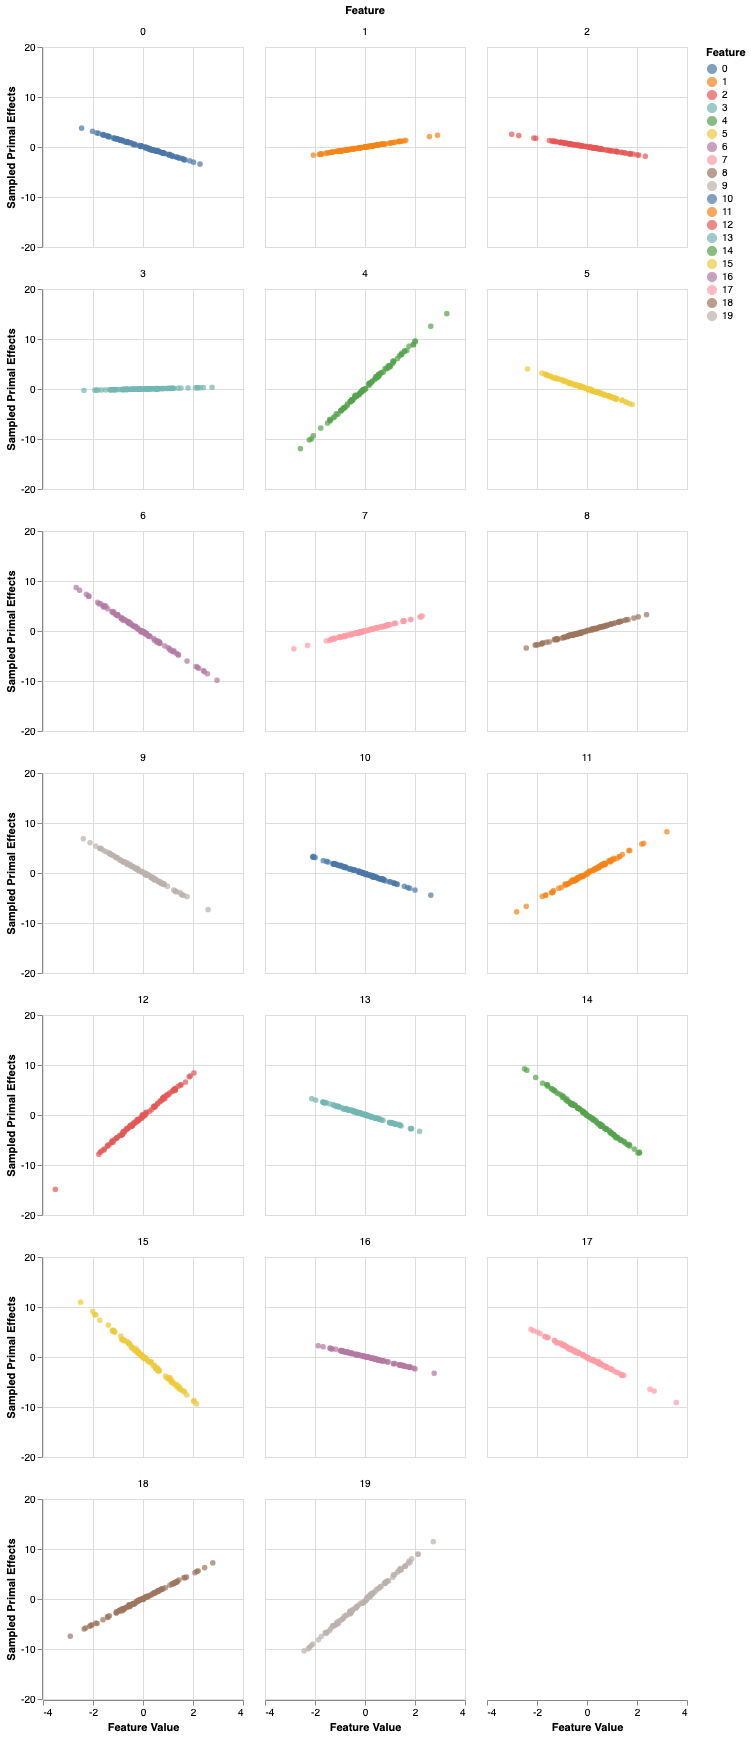

In [14]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.Y('Sampled Primal Effects:Q'),
    alt.X('Feature Value:Q'),
    alt.Color('Feature:N'),
    alt.Facet('Feature:N')
).properties(
    columns=3,
    width=200,
    height=200
)

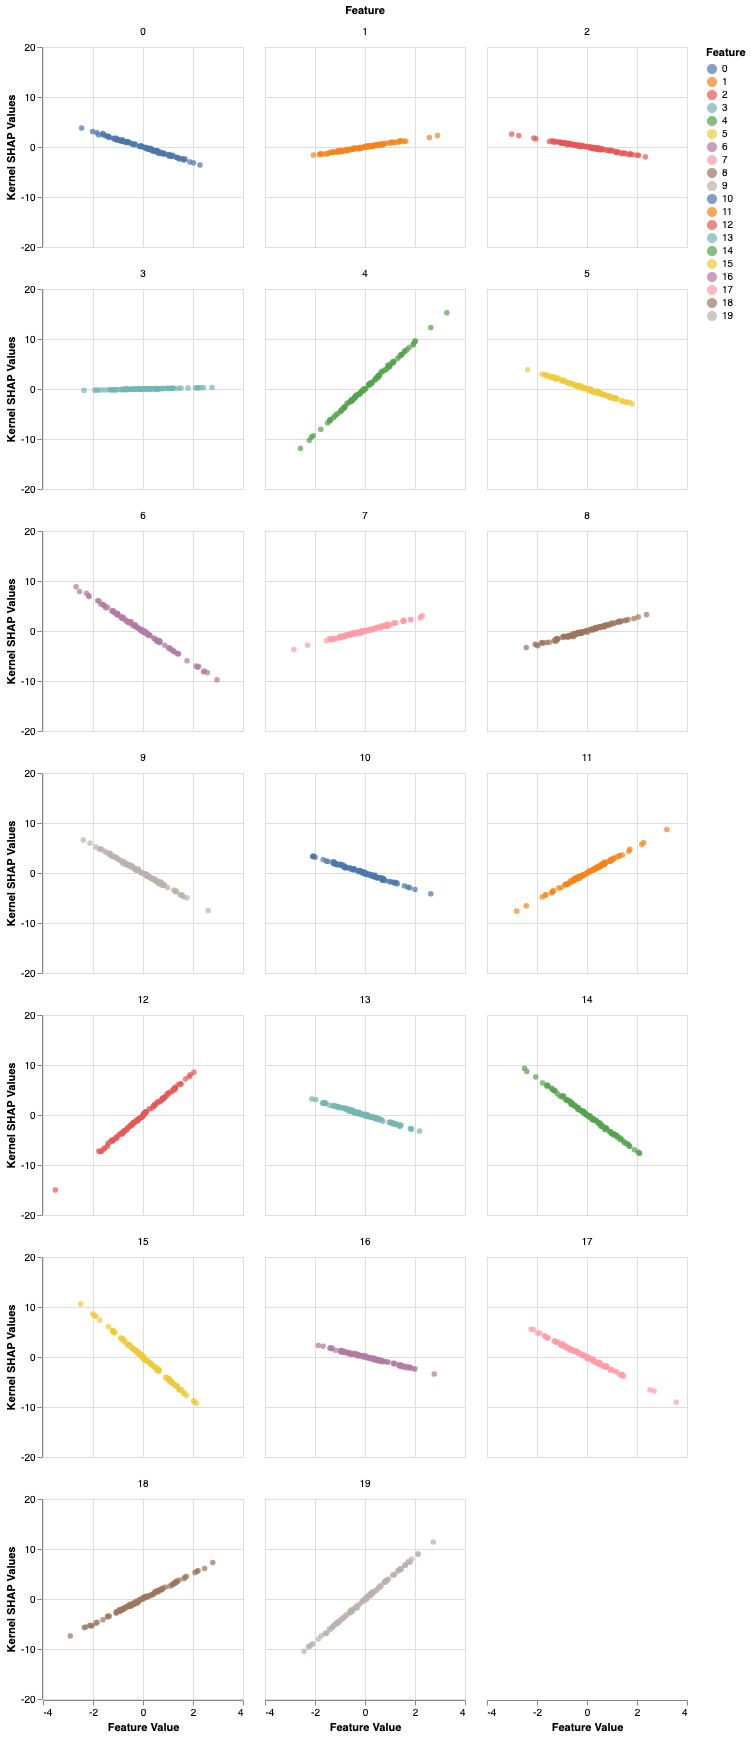

In [15]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.Y('Kernel SHAP Values:Q'),
    alt.X('Feature Value:Q'),
    alt.Color('Feature:N'),
    alt.Facet('Feature:N')
).properties(
    columns=3,
    width=200,
    height=200
)

### Interaction Plot
Below we plot the interaction values for each feature. As expected, they are close to zero (notice the scale on the y-axis relative to the plots above).

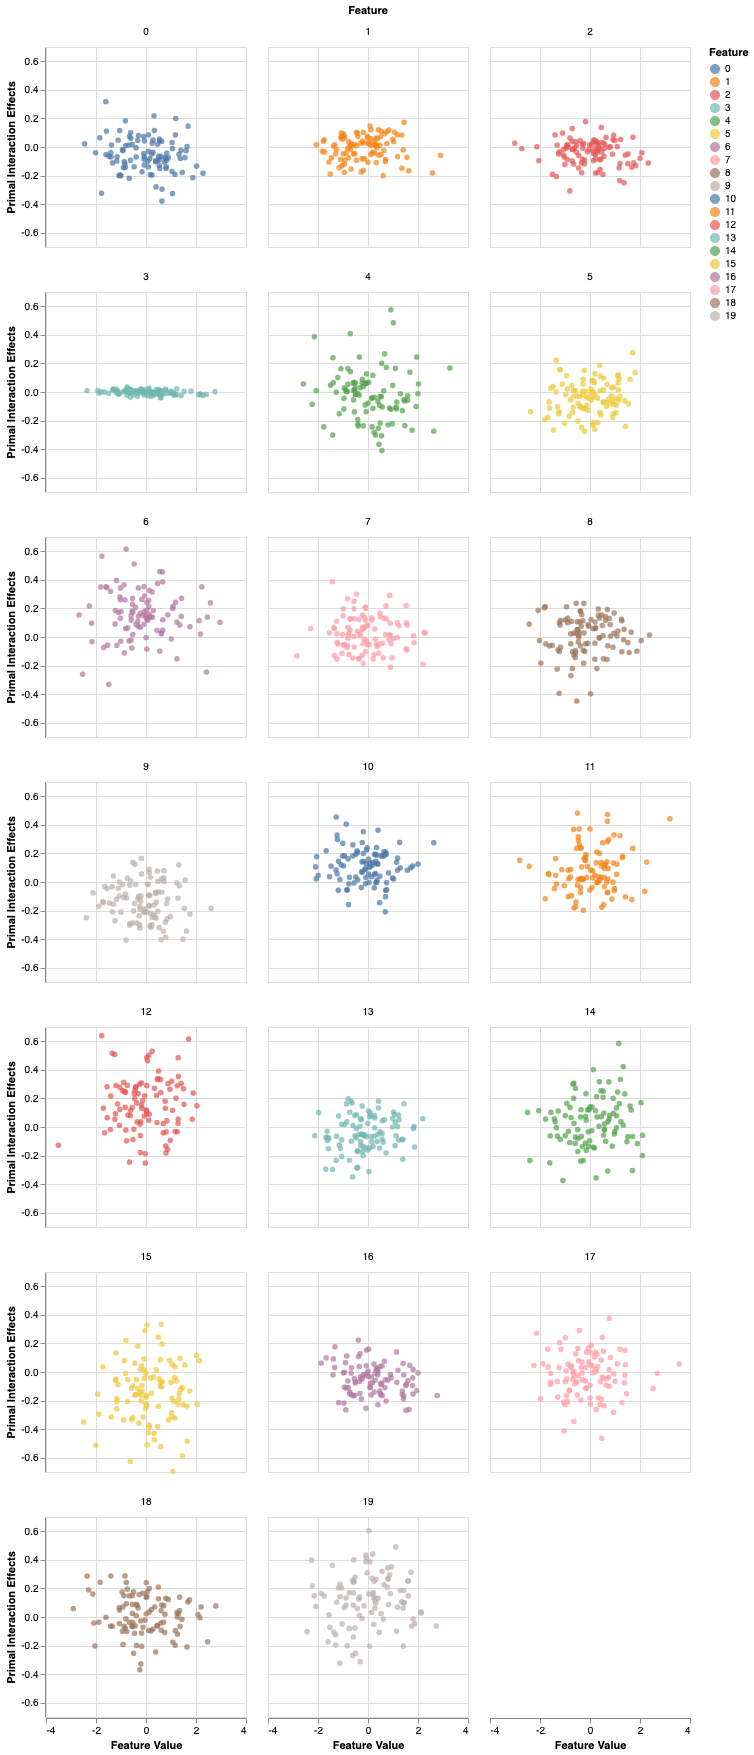

In [16]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.Y('Primal Interaction Effects:Q'),
    alt.X('Feature Value:Q'),
    alt.Color('Feature:N'),
    alt.Facet('Feature:N')
).properties(
    columns=3,
    width=200,
    height=200
)

### Global Bar Plots
We can plot the above information by aggregating over samples (mean of absolute value). We see that the main effects match the true SHAP values, and the interaction effects are quite low. Strictly speaking, they are not equal to zero because there is variance in the sampling-based approach I use to compute the main effects.

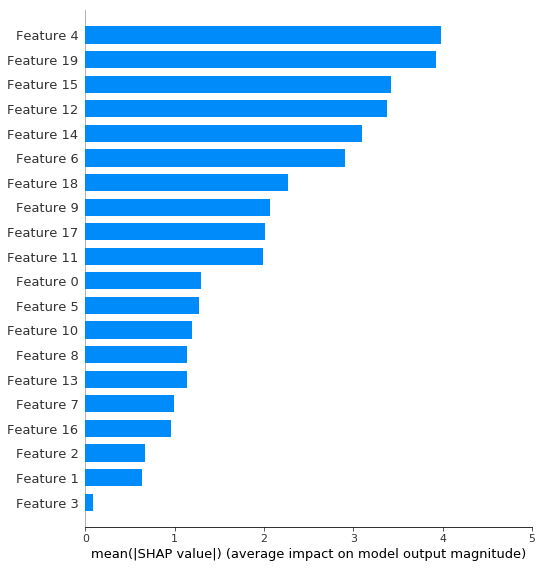

In [17]:
plot.summary_plot(kernel_shap, X[:num_shap_samples], plot_type='bar', xlim=(0.0, 5.0))

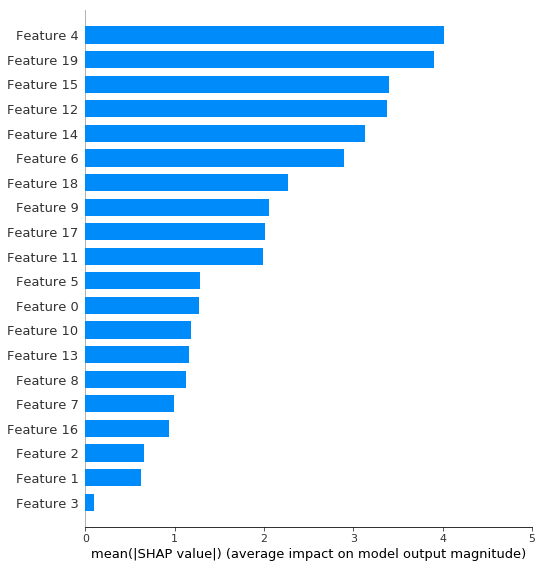

In [18]:
plot.summary_plot(primal_effects, X[:num_shap_samples], plot_type='bar', xlim=(0.0, 5.0))

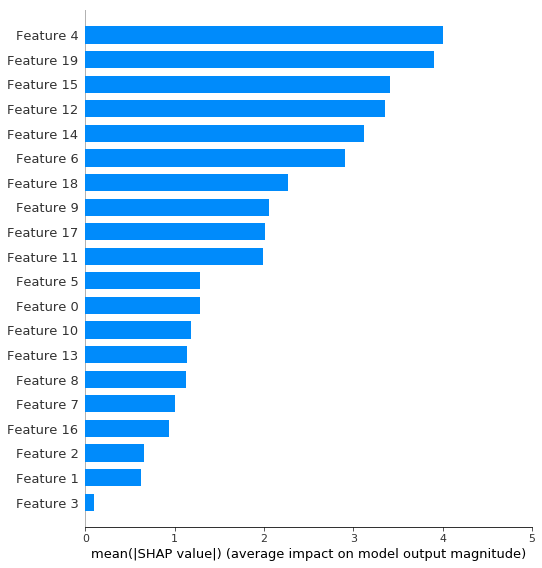

In [19]:
plot.summary_plot((X[:num_shap_samples] * W), X[:num_shap_samples], plot_type='bar', xlim=(0.0, 5.0))

In [20]:
empirical_covariance = np.cov(X.T)
np.fill_diagonal(empirical_covariance, 0)
mean_abs_off_diag_cov = np.mean(np.abs(empirical_covariance), axis=0)

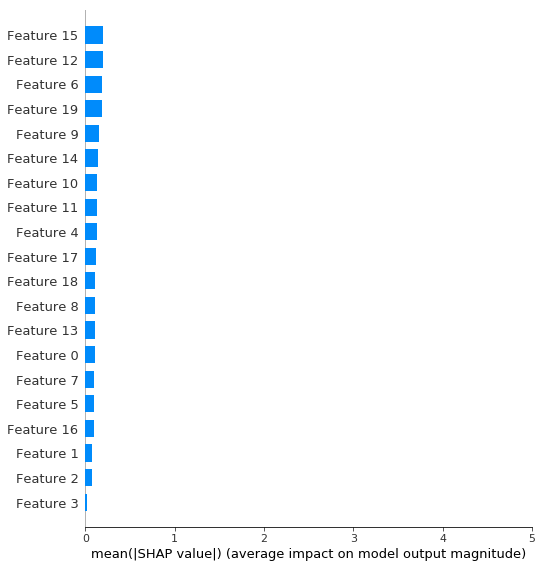

In [21]:
plot.summary_plot(kernel_shap - primal_effects, X[:num_shap_samples], plot_type='bar', xlim=(0.0, 5.0))

### Examining a Single Sample
We can examine a single feature and plot the SHAP values for that feature in a bar plot. If we decompose the bar plot in terms of its main and 

In [22]:
ind_df = pd.DataFrame({
    'Primal Main Effect': primal_effects[0],
    'Interaction Effect': kernel_shap[0] - primal_effects[0],
    'Feature': np.arange(kernel_shap.shape[1])
})

melted_df = pd.melt(ind_df, id_vars=['Feature'], value_name='Kernel SHAP Value', var_name='Effect Type')

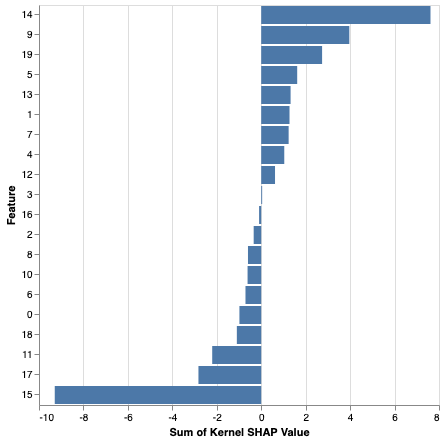

In [23]:
alt.Chart(melted_df).mark_bar().encode(
    alt.X('sum(Kernel SHAP Value):Q'),
    alt.Y('Feature:N', sort=alt.EncodingSortField(
            field="Kernel SHAP Value",
            order="descending" 
        ))
)

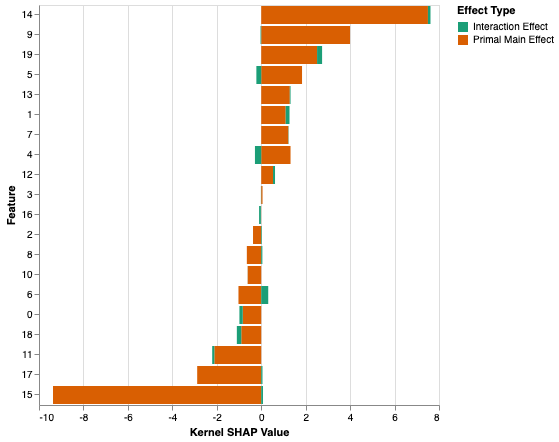

In [24]:
alt.Chart(melted_df).mark_bar().encode(
    alt.X('Kernel SHAP Value:Q'),
    alt.Y('Feature:N', sort=list(np.argsort(kernel_shap[0])[::-1])),
    alt.Color('Effect Type:N', scale=alt.Scale(scheme='dark2'))
)